In [1]:
from google.colab import drive
import os
import zipfile
import shutil
drive.mount('/content/drive')
zip_path = "/content/drive/My Drive/dataset.zip"
extract_path = "/content/dataset"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 6698 images belonging to 82 classes.
Found 1145 images belonging to 82 classes.
Epoch 1/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 216s 693ms/step - accuracy: 0.0223 - loss: 4.5422 - val_accuracy: 0.0166 - val_loss: 4.5701
Epoch 2/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 110s 525ms/step - accuracy: 0.1711 - loss: 3.9247 - val_accuracy: 0.0533 - val_loss: 4.4206
Epoch 3/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 105s 498ms/step - accuracy: 0.4311 - loss: 2.7797 - val_accuracy: 0.1991 - val_loss: 3.7962
Epoch 4/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 102s 484ms/step - accuracy: 0.5898 - loss: 1.9503 - val_accuracy: 0.3406 - val_loss: 3.2152
Epoch 5/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 104s 493ms/step - accuracy: 0.7091 - loss: 1.4288 - val_accuracy: 0.1476 - val_loss: 4.0563
Epoch 6/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 106s 504ms/step - accuracy: 0.7607 - loss: 1.1629 - val_accuracy: 0.0638 - val_loss: 5.7181
Epoch 7/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 105s 501ms/step - accuracy: 0.8066 - loss: 0.9979 - val_accuracy: 0.1284 - val_los

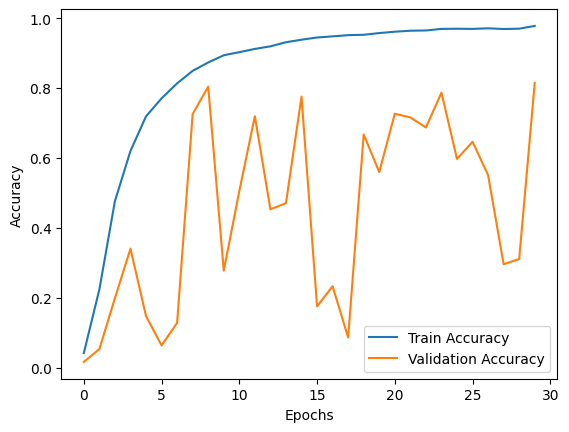

Found 1964 images belonging to 82 classes.
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.8435 - loss: 0.8247
Test Loss: 0.7771419286727905
Test Accuracy: 0.8503054976463318


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

train_dir = "/content/dataset/dataset/train"
test_dir = "/content/dataset/dataset/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

fine_tune_at = 120

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(82, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(82, activation='softmax')
])


optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

best_val_acc = 0.0
best_model_path = "/content/drive/My Drive/best_efficientnet_model.h5"

history = model.fit(train_generator, validation_data=val_generator, epochs=30)

for i in range(len(history.history['val_accuracy'])):
    if history.history['val_accuracy'][i] > best_val_acc:
        best_val_acc = history.history['val_accuracy'][i]
        model.save(best_model_path)

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


In [14]:
model.save('my_model.keras')

In [ ]:
from sklearn.metrics import classification_report
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.metrics import Recall, Precision
model_path = '/content/drive/My Drive/my_model.keras'
model = tf.keras.models.load_model(model_path)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])
test_dir = "/content/dataset/dataset/test"
test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_acc, test_recall, test_precision = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")


Found 1964 images belonging to 82 classes.
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.8407 - loss: 0.7662 - precision_2: 0.8821 - recall_2: 0.8093
Test Loss: 0.777141809463501
Test Accuracy: 0.8503054976463318
Test Recall: 0.8228105902671814
Test Precision: 0.8947951197624207
